# Sentiment Classification


### Generate Word Embeddings and retrieve outputs of each layer with Keras based on Classification task

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.

It is a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

We willl use the imdb dataset to learn word embeddings as we train our dataset. This dataset contains 25,000 movie reviews from IMDB, labeled with sentiment (positive or negative). 



### Dataset

`from keras.datasets import imdb`

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning the for that has index 1 is the most frequent word. Use the first 20 words from each review to speed up training, using a max vocab size of 10,000.

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.


### Aim

1. Import test and train data  
2. Import the labels ( train and test) 
3. Get the word index and then Create key value pair for word and word_id. (12.5 points)
4. Build a Sequential Model using Keras for Sentiment Classification task. (10 points)
5. Report the Accuracy of the model. (5 points)  
6. Retrive the output of each layer in keras for a given single test sample from the trained model you built. (2.5 points)


#### Usage:

In [0]:
import keras

In [6]:
from keras.datasets import imdb

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

ValueError: ignored

In [0]:
x_train## We see that the comments are already converted into numbers 

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [0]:
import numpy as np
np.unique(y_train,return_counts=True) ## this conforms only 2 classes 
##in the train set hence this is a binary classification with no outliers.

(array([0, 1]), array([12500, 12500]))

In [0]:
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

In [0]:
#load dataset as a list of ints
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

## Build Keras Embedding Layer Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [0]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 2, input_length=300))
model.add(keras.layers.Flatten())
# dropout regularization
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(5))
# for binary classification, use sigmoid
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 2)            20000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 600)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 3005      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 23,011
Trainable params: 23,011
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
## Below model is trained with epoc as 20 and batch size as 50 
## this can be seen that the model gives a pretty decent accuracy of 90+ and 86+ in train and val resp.
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=50,
                    validation_data=(x_test, y_test),
                    verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 2s 67us/step - loss: 0.1743 - acc: 0.9278 - val_loss: 0.3437 - val_acc: 0.8662
Epoch 2/20
25000/25000 [==============================] - 2s 62us/step - loss: 0.1726 - acc: 0.9301 - val_loss: 0.3426 - val_acc: 0.8683
Epoch 3/20
25000/25000 [==============================] - 2s 60us/step - loss: 0.1719 - acc: 0.9297 - val_loss: 0.3461 - val_acc: 0.8661
Epoch 4/20
25000/25000 [==============================] - 2s 60us/step - loss: 0.1677 - acc: 0.9320 - val_loss: 0.3418 - val_acc: 0.8685
Epoch 5/20
25000/25000 [==============================] - 2s 61us/step - loss: 0.1667 - acc: 0.9332 - val_loss: 0.3436 - val_acc: 0.8682
Epoch 6/20
25000/25000 [==============================] - 2s 72us/step - loss: 0.1680 - acc: 0.9318 - val_loss: 0.3498 - val_acc: 0.8696
Epoch 7/20
25000/25000 [==============================] - 2s 63us/step - loss: 0.1667 - acc: 0.9329 - val_loss: 0.3515 - val_acc

In [0]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
     acc = history.history['acc']
    test_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    if miny:
    plt.ylim(miny, 1.0)
    plt.title('accuracy') 
    plt.xlabel('epoch')
    plt.figure()

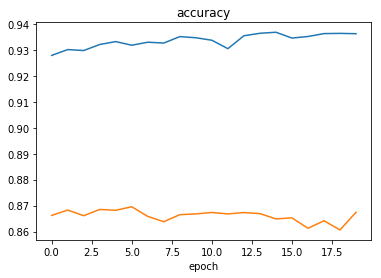

<Figure size 432x288 with 0 Axes>

In [0]:
plot_accuracy(history)

## Retrive the output of each layer in keras for a given single test sample from the trained model you built

In [0]:
## Lets see the output from the test set 
x_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
## lets first see how many outputs are there 
for layer in model.layers:
    print(layer.output)

Tensor("embedding_2/embedding_lookup/Identity:0", shape=(?, 300, 2), dtype=float32)
Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dropout_2/cond/Merge:0", shape=(?, ?), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(?, 5), dtype=float32)
Tensor("dense_4/Sigmoid:0", shape=(?, 1), dtype=float32)


In [0]:
get_out_func = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

In [0]:
test_input=x_test[0]

In [0]:
layer_output = get_out_func([test_input])
print(type(layer_output), len(layer_output), layer_output[0].shape)

<class 'list'> 1 (300, 2)


In [0]:
layer_output[0]

array([[-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.26574657e-03,  1.17637392e-04],
       [-4.

In [0]:
## visually view the ouput to see the Word embedding.
review_words =layer_output[0]

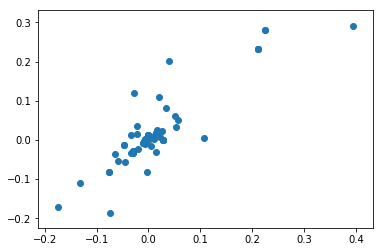

In [0]:
## the below figure shows the word embedding means clusterring the similar words together.
plt.scatter(review_words[:,0], review_words[:,1])